# Getting Started with Error Mitigation with mitiq on Braket 

The presence of errors in quantum computing ultimately hinders their application as well. The simplest model, i.e. local or globabl depolarizing noise, represents how noise generally removes information from a quantum system. Error mitigation attempts to, similar to improving a signal-to-noise ratio, generally at the cost of repeated measurements. 

mitiq is an open source Python toolkit for implementing error mitigation techniques, which covers a breadth of different methodoloies and tools. 

In these notebooks, we show to utilize mitiq with Amazon Braket, specifically focusing on utilizing Program Sets to orchestrate our job submissions. 

## Overview on mitiq 
 
mitiq contains two methods for applying error mitigation generally. The first can be thought of as an automated way of calling error mitigation functions and then having an output returns. The second unpacks this procedure, separating the creation of circuits and their application and reassembly. 

Further details can be found at https://mitiq.readthedocs.io/en/stable/guide/guide.html

In this example, we focus on the latter, as 

## Overview of Error Mitigation Techniques

The mitiq library provides numerous error mitigation approaches as pre-implemented strategies. 

### Using Verbatim Circuits

For most of these approaches, we will want to treat the circuit as a Verbatim circuit. This creates a more reliable thread between the submitted circuits and the hypothetical noise model which is being manipulated. If we were to submit as a non-verbatim circuit, we would likely 

#### Readout Error Mitigation

Readout error mitigation is perhaps the most common error mitigation technique. The standard approach involves the construction of a confusion matrix, relating prepared input states to  measured output states. Specifically

In postprocessing, we can apply the inverse of this matrix to try and account for these errors. The statistical variance is increased as a result, related by the cost of the inverse matrix generally. However, because this is essentially a one-time-cost, and can drastically help to defend against readout errors, this approach is extremely common.  


#### Zero Noise Extrapolation



#### Probabilistic Error Cancellation

Probabilistic error cancellation forms the backbone of some of the most successful error mitigation strategies used  today, but can also be the most technical to implement. 

### Using mitiq

In mitiq, we are primarily focused on an executor, which can either output an observable, measurement result, or a 

Resolve Imports 

In [1]:
import os
import sys

# from mitiq_tools import get_emulator
from mitiq import MeasurementResult
from mitiq.rem import post_select, execute_with_rem, mitigate_executor, mitigate_measurements, rem_decorator
from mitiq.rem.inverse_confusion_matrix import sample_probability_vector, generate_inverse_confusion_matrix, generate_tensored_inverse_confusion_matrix
from braket.circuits.observables import I, Z
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from noise_models import qd_depol, qd_readout

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent directory 
# qd = get_emulator() # here we can specify any device to return the noisy emulator 
from qiskit import transpile, QuantumCircuit
from qiskit_braket_provider import to_braket, to_qiskit
from qiskit_braket_provider.providers.adapter import aws_device_to_target
import numpy as np 
from tools import run_with_program_sets

from braket.emulation.local_emulator import LocalEmulator
import json

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)

# target = aws_device_to_target(qd)

## Readout Error Mitigation

Let's start with a simple readout error mitigation. 

Normally we would 

In [49]:
# let's get a 6-qubit local readout 

results = []
shots = []

for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"])
    results.append(qd.run(circ.measure(range(6)),shots=10000).result().measurement_probabilities)

print(circ)



/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.570796

T  : │         0         │  1  │
      ┌─────────────────┐ ┌───┐ 
q0 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q1 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q2 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q3 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q4 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q5 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
T  : │         0         │  1  │


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(


In [64]:
cm = np.zeros((2**6,2**6))
np.set_printoptions(precision=3,linewidth=400,suppress=True)

for n,meas_results in enumerate(results):
    for k,v in meas_results.items():
        cm[n , int(k,2)] = v

for i in range(64):
    print(cm[:,i])

[0.819 0.061 0.017 0.002 0.016 0.001 0.001 0.    0.054 0.004 0.001 0.    0.001 0.    0.    0.    0.017 0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.066 0.819 0.002 0.02  0.001 0.016 0.    0.    0.005 0.054 0.    0.002 0.    0.001 0.    0.    0.001 0.017 0.    0.001 0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.021 0.002 0.825 0.061 0.001 0.    0.016 0.001 0.001 0.    0.051 0.004 0.    0.    0.001 0.    0.    0.    0.016 0.001 0.    0.    0.001 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [65]:
test = generate_tensored_inverse_confusion_matrix(6, confusion_matrices=[cm])
print(test)




[[ 1.234 -0.099 -0.031 ...  0.     0.     0.   ]
 [-0.092  1.236  0.002 ...  0.     0.     0.   ]
 [-0.026  0.002  1.226 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  1.236  0.002 -0.031]
 [ 0.     0.     0.    ...  0.002  1.244 -0.099]
 [ 0.     0.     0.    ... -0.03  -0.094  1.238]]


In [69]:
circ = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(2,3).cnot(3,4).cnot(4,5).measure(range(6))
circ = to_braket(to_qiskit(circ, add_measurements=False), 
                    basis_gates = ["r", "cz","barrier", "measure"])
# 

raw_results = []

@rem_decorator(inverse_confusion_matrix=test)
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

res = GHZ_res(circ).get_counts()
print(res)
print(raw_results)



{'111111': 4748, '000000': 5139, '111011': 4, '000001': 7, '111000': 7, '111110': 26, '011111': 8, '100000': 8, '111101': 8, '000010': 11, '000111': 10, '110100': 2, '000101': 3, '001111': 4, '110011': 1, '100110': 1, '111100': 6, '110000': 2, '010001': 1, '000011': 2, '101110': 1, '001011': 1}
[Counter({'000000': 4087, '111111': 3986, '111110': 341, '000001': 318, '001000': 263, '110111': 253, '111101': 108, '000010': 104, '010000': 87, '111011': 82, '000100': 80, '101111': 79, '001001': 19, '110110': 18, '000011': 18, '111100': 16, '001111': 12, '100000': 12, '000111': 9, '101110': 8, '111000': 8, '011111': 8, '010001': 8, '000101': 8, '110011': 7, '001011': 5, '111010': 5, '001010': 4, '010100': 4, '110101': 4, '100111': 4, '110000': 4, '110100': 3, '010010': 3, '011000': 3, '001100': 3, '111001': 3, '011101': 2, '101011': 2, '010011': 1, '000110': 1, '011100': 1, '010111': 1, '001110': 1, '001101': 1, '100101': 1, '011110': 1, '101101': 1, '101010': 1, '100001': 1, '011001': 1})]


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


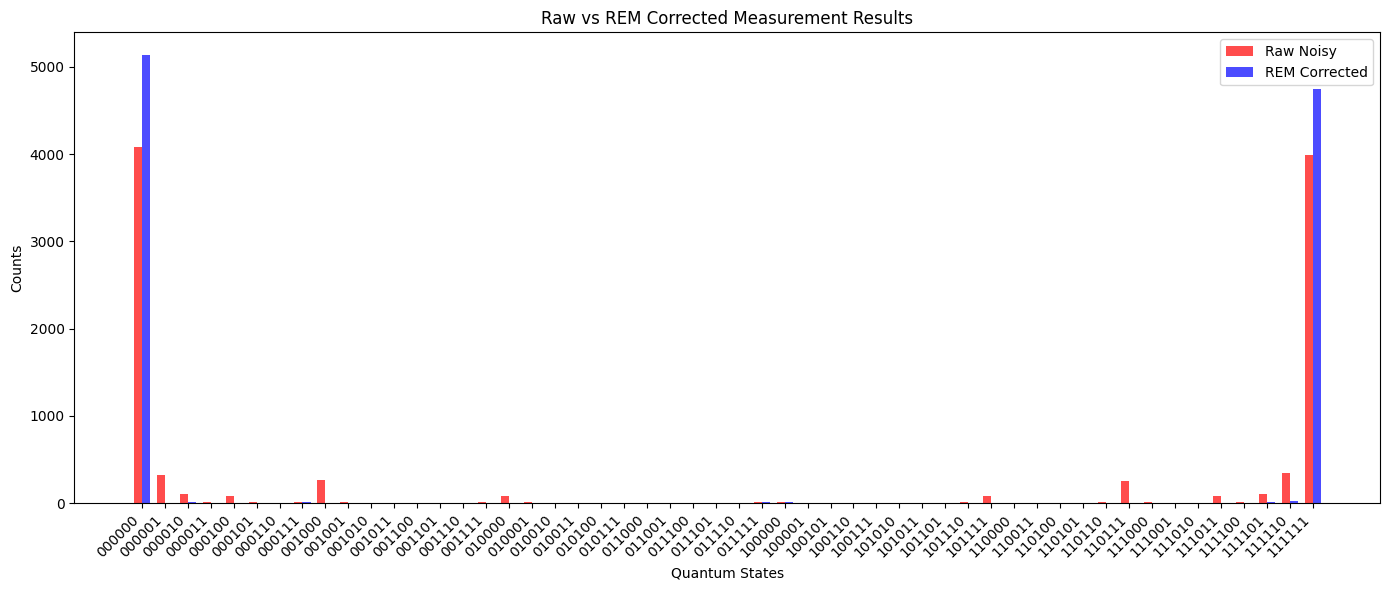

In [70]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

all_states = sorted(set(raw_counts.keys()) | set(corrected_counts.keys()))
raw_values = [raw_counts.get(state, 0) for state in all_states]
corr_values = [corrected_counts.get(state, 0) for state in all_states]


plt.figure(figsize=(14, 6))
x = range(len(all_states))
width = 0.35
plt.bar([i - width/2 for i in x], raw_values, width, label='Raw Noisy', color='red', alpha=0.7)
plt.bar([i + width/2 for i in x], corr_values, width, label='REM Corrected', color='blue', alpha=0.7)
plt.xlabel('Quantum States')
plt.ylabel('Counts')
plt.title('Raw vs REM Corrected Measurement Results')
plt.xticks(x, all_states, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

With program sets, we can streamline this execution. Namely, we have that:


In [75]:
# let's get a 6-qubit local readout 
from braket.program_sets import ProgramSet

circuits = []
for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"],qubit_labels=[1,2,6,12,11,5])
    circuits.append(circ.measure(range(6)))

pset = ProgramSet(circuits, shots_per_executable=10000)

result = qd.run(pset).result()



/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 3.141592653589793 will not be included in Braket circuit
  warnings.warn(
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 1.570796

This can be performed in a single submission, reducing queue times and total cost \$0.32 * (64-1) ~ \$19, just from job submission. 

### Zero Noise Extrapolation 

Zero noise extrapolation represent a common error mitigation pattern. # Well, when do we not need an exponential extrapolation? 

#
## 
# 

# 

# 

T  : │          0          │         1          │  2  │          3          │         4          │  5  │          6          │         7         │  8  │          9          │         10         │ 11  │         12          │        13         │
      ┌───────────────────┐ ┌─────────────────┐                                                          ┌─────────────────┐  ┌─────────────────┐                                                                                                  
q0 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├──────────────────────────────────────────────────────────────────────────────────────────────────
      └───────────────────┘ └─────────────────┘    │                                                │    └─────────────────┘  └─────────────────┘                                                                                                  
      ┌─────────────────

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/qiskit_braket_provider/providers/adapter.py:903: UserWarning: Device does not support global phase; global phase of 6.283185307179572 will not be included in Braket circuit
  warnings.warn(


Now, let's run this sample.

In [ ]:
import matplotlib.pyplot as plt 
qd_exact = LocalSimulator()
obs = Circuit()
for i in range(10):
    obs.expectation(Z())

circ = Circuit()
ideal_evs = []
ideal_stds = []
for steps in range(20):
    circ+= test
    res = qd_exact.run(circ + obs, shots = 0).result()
    ideal_evs.append(np.average(res.values))
    ideal_stds.append(np.std(res.values))



<ErrorbarContainer object of 3 artists>

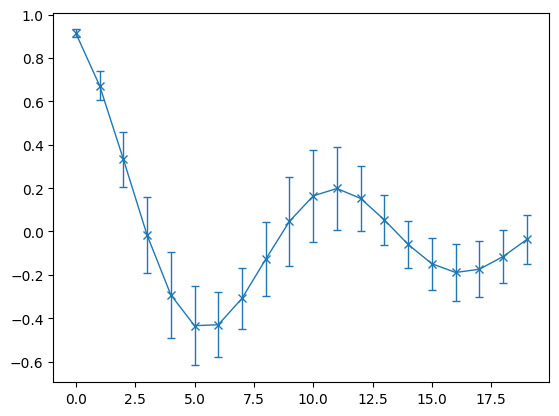

In [40]:
plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1)

In [ ]:
obs = Circuit()
for i in range(10):
    obs.expectation(Z())

noisy_circ = Circuit()
noisy_evs = []
noisy_stds = []
for steps in range(10):
    print(steps)
    circ+= test + test
    res = qd.run(circ + obs, shots = 1000).result()
    noisy_evs.append(np.average(res.values))
    noisy_stds.append(np.std(res.values))


0
1
2
3
4
5
6
7
8
9


In [ ]:
print(test + test)


T  : │          0          │         1          │  2  │          3          │         4          │  5  │          6          │         7         │          8          │          9          │         10         │ 11  │         12          │        13         │         14          │         15         │ 16  │         17          │         18         │ 19  │         20          │        21         │ 22  │         23          │         24         │ 25  │         26          │        27         │
      ┌───────────────────┐ ┌─────────────────┐                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐                                                                                                  
q0 : ─

<ErrorbarContainer object of 3 artists>

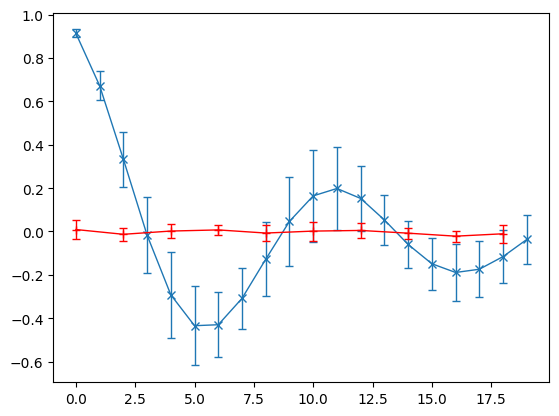

In [45]:
plt.errorbar(range(len(ideal_evs)), ideal_evs, ideal_stds, capsize=3, marker='x',linewidth=1,
             label="ideal"
             )
plt.errorbar(range(0,2*len(noisy_evs),2), noisy_evs, noisy_stds, capsize=3, marker='+',c='r',linewidth=1,
             label="noisy")

Now, let's add zero-noise extrapolation

In [47]:
construct_circuits

obs = Circuit()
for i in range(10):
    obs.expectation(Z())

noisy_circ = Circuit()
noisy_evs = []
noisy_stds = []
for steps in range(10):
    print(steps)
    circ+= test + test
    circuits = construct_circuits(circ + obs, [1, 1.5, 2.0])
    res = qd.run(circ + obs, shots = 1000).result()
    noisy_evs.append(np.average(res.values))
    noisy_stds.append(np.std(res.values))


0


CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfoundation/mitiq. 

 Provided circuit has type <class 'braket.circuits.circuit.Circuit'> and is:

T  : │          0          │         1          │  2  │          3          │         4          │  5  │          6          │         7         │          8          │          9          │         10         │ 11  │         12          │        13         │         14          │         15         │ 16  │         17          │         18         │ 19  │         20          │        21         │         22          │         23          │         24         │ 25  │         26          │        27         │         28          │         29         │ 30  │         31          │         32         │ 33  │         34          │        35         │         36          │         37          │         38         │ 39  │         40          │        41         │         42          │         43         │ 44  │         45          │         46         │ 47  │         48          │        49         │         50          │         51          │         52         │ 53  │         54          │        55         │         56          │         57         │ 58  │         59          │         60         │ 61  │         62          │        63         │         64          │         65          │         66         │ 67  │         68          │        69         │         70          │         71         │ 72  │         73          │         74         │ 75  │         76          │        77         │         78          │         79          │         80         │ 81  │         82          │        83         │         84          │         85         │ 86  │         87          │         88         │ 89  │         90          │        91         │         92          │         93          │         94         │ 95  │         96          │        97         │         98          │         99         │ 100 │         101         │        102         │ 103 │         104         │        105        │         106         │         107         │        108         │ 109 │         110         │        111        │         112         │        113         │ 114 │         115         │        116         │ 117 │         118         │        119        │         120         │         121         │        122         │ 123 │         124         │        125        │         126         │        127         │ 128 │         129         │        130         │ 131 │         132         │        133        │         134         │         135         │        136         │ 137 │         138         │        139        │         140         │        141         │ 142 │         143         │        144         │ 145 │         146         │        147        │         148         │         149         │        150         │ 151 │         152         │        153        │         154         │        155         │ 156 │         157         │        158         │ 159 │         160         │        161        │         162         │         163         │        164         │ 165 │         166         │        167        │         168         │        169         │ 170 │         171         │        172         │ 173 │         174         │        175        │         176         │         177         │        178         │ 179 │         180         │        181        │         182         │        183         │ 184 │         185         │        186         │ 187 │         188         │        189        │         190         │         191         │        192         │ 193 │         194         │        195        │         196         │        197         │ 198 │         199         │        200         │ 201 │         202         │        203        │         204         │         205         │        206         │ 207 │         208         │        209        │         210         │        211         │ 212 │         213         │        214         │ 215 │         216         │        217        │         218         │         219         │        220         │ 221 │         222         │        223        │         224         │        225         │ 226 │         227         │        228         │ 229 │         230         │        231        │         232         │         233         │        234         │ 235 │         236         │        237        │         238         │        239         │ 240 │         241         │        242         │ 243 │         244         │        245        │         246         │         247         │        248         │ 249 │         250         │        251        │         252         │        253         │ 254 │         255         │        256         │ 257 │         258         │        259        │         260         │         261         │        262         │ 263 │         264         │        265        │         266         │        267         │ 268 │         269         │        270         │ 271 │         272         │        273        │         274         │         275         │        276         │ 277 │         278         │        279        │         280         │        281         │ 282 │         283         │        284         │ 285 │         286         │        287        │         288         │         289         │        290         │ 291 │         292         │        293        │         294         │        295         │ 296 │         297         │        298         │ 299 │         300         │        301        │         302         │         303         │        304         │ 305 │         306         │        307        │         308         │        309         │ 310 │         311         │        312         │ 313 │         314         │        315        │         316         │         317         │        318         │ 319 │         320         │        321        │         322         │        323         │ 324 │         325         │        326         │ 327 │         328         │        329        │         330         │         331         │        332         │ 333 │         334         │        335        │         336         │        337         │ 338 │         339         │        340         │ 341 │         342         │        343        │         344         │         345         │        346         │ 347 │         348         │        349        │         350         │        351         │ 352 │         353         │        354         │ 355 │         356         │        357        │         358         │         359         │        360         │ 361 │         362         │        363        │         364         │        365         │ 366 │         367         │        368         │ 369 │         370         │        371        │         372         │         373         │        374         │ 375 │         376         │        377        │         378         │        379         │ 380 │         381         │        382         │ 383 │         384         │        385        │         386         │         387         │        388         │ 389 │         390         │        391        │         392         │        393         │ 394 │         395         │        396         │ 397 │         398         │        399        │         400         │         401         │        402         │ 403 │         404         │        405        │         406         │        407         │ 408 │         409         │        410         │ 411 │         412         │        413        │         414         │         415         │        416         │ 417 │         418         │        419        │         420         │        421         │ 422 │         423         │        424         │ 425 │         426         │        427        │         428         │         429         │        430         │ 431 │         432         │        433        │         434         │        435         │ 436 │         437         │        438         │ 439 │         440         │        441        │         442         │         443         │        444         │ 445 │         446         │        447        │         448         │        449         │ 450 │         451         │        452         │ 453 │         454         │        455        │         456         │         457         │        458         │ 459 │         460         │        461        │         462         │        463         │ 464 │         465         │        466         │ 467 │         468         │        469        │         470         │         471         │        472         │ 473 │         474         │        475        │         476         │        477         │ 478 │         479         │        480         │ 481 │         482         │        483        │         484         │         485         │        486         │ 487 │         488         │        489        │         490         │        491         │ 492 │         493         │        494         │ 495 │         496         │        497        │         498         │         499         │        500         │ 501 │         502         │        503        │         504         │        505         │ 506 │         507         │        508         │ 509 │         510         │        511        │         512         │         513         │        514         │ 515 │         516         │        517        │         518         │        519         │ 520 │         521         │        522         │ 523 │         524         │        525        │         526         │         527         │        528         │ 529 │         530         │        531        │         532         │        533         │ 534 │         535         │        536         │ 537 │         538         │        539        │         540         │         541         │        542         │ 543 │         544         │        545        │         546         │        547         │ 548 │         549         │        550         │ 551 │         552         │        553        │         554         │         555         │        556         │ 557 │         558         │        559        │         560         │        561         │ 562 │         563         │        564         │ 565 │         566         │        567        │         568         │         569         │        570         │ 571 │         572         │        573        │         574         │        575         │ 576 │         577         │        578         │ 579 │         580         │        581        │         582         │         583         │        584         │ 585 │         586         │        587        │         588         │        589         │ 590 │         591         │        592         │ 593 │         594         │        595        │         596         │         597         │        598         │ 599 │         600         │        601        │         602         │        603         │ 604 │         605         │        606         │ 607 │         608         │        609        │         610         │         611         │        612         │ 613 │         614         │        615        │         616         │        617         │ 618 │         619         │        620         │ 621 │         622         │        623        │         624         │         625         │        626         │ 627 │         628         │        629        │         630         │        631         │ 632 │         633         │        634         │ 635 │         636         │        637        │         638         │         639         │        640         │ 641 │         642         │        643        │         644         │        645         │ 646 │         647         │        648         │ 649 │         650         │        651        │         652         │         653         │        654         │ 655 │         656         │        657        │         658         │        659         │ 660 │         661         │        662         │ 663 │         664         │        665        │         666         │         667         │        668         │ 669 │         670         │        671        │         672         │        673         │ 674 │         675         │        676         │ 677 │         678         │        679        │         680         │         681         │        682         │ 683 │         684         │        685        │         686         │        687         │ 688 │         689         │        690         │ 691 │         692         │        693        │         694         │         695         │        696         │ 697 │         698         │        699        │         700         │        701         │ 702 │         703         │        704         │ 705 │         706         │        707        │         708         │         709         │        710         │ 711 │         712         │        713        │         714         │        715         │ 716 │         717         │        718         │ 719 │         720         │        721        │         722         │         723         │        724         │ 725 │         726         │        727        │         728         │        729         │ 730 │         731         │        732         │ 733 │         734         │        735        │         736         │         737         │        738         │ 739 │         740         │        741        │         742         │        743         │ 744 │         745         │        746         │ 747 │         748         │        749        │         750         │         751         │        752         │ 753 │         754         │        755        │         756         │        757         │ 758 │         759         │        760         │ 761 │         762         │        763        │ 764 │         765         │        766         │ 767 │         768         │        769        │   Result Types   │
      ┌───────────────────┐ ┌─────────────────┐                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐ ┌───────────────────┐  ┌─────────────────┐                                                                                                                                                                          ┌─────────────────┐  ┌─────────────────┐                                                                                                  ┌────────────────┐ 
q0 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-1.67, -1.57) ├──┤ PRx(3.14, 0.00) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├──────────────────────────────────────────────────────────────────────────────────────────────────┤ Expectation(Z) ├─
      └───────────────────┘ └─────────────────┘    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘ └───────────────────┘  └─────────────────┘                                                                                                                    │                                                │    └─────────────────┘  └─────────────────┘                                                                                                  └───────┬────────┘ 
      ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌─────────────────┐  ┌─────────────────┐ ┌───────┴────────┐ 
q1 : ─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ Expectation(Z) ├─
      └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘   │                                                │    └─────────────────┘  └─────────────────┘ └───────┬────────┘ 
      ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────┴────────┐ 
q2 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ Expectation(Z) ├─
      └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────┬────────┘ 
      ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌─────────────────┐  ┌─────────────────┐ ┌───────┴────────┐ 
q3 : ─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ Expectation(Z) ├─
      └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘   │                                                │    └─────────────────┘  └─────────────────┘ └───────┬────────┘ 
      ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────┴────────┐ 
q4 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ Expectation(Z) ├─
      └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────┬────────┘ 
      ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌─────────────────┐  ┌─────────────────┐ ┌───────┴────────┐ 
q5 : ─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ Expectation(Z) ├─
      └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘   │                                                │    └─────────────────┘  └─────────────────┘ └───────┬────────┘ 
      ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────┴────────┐ 
q6 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ Expectation(Z) ├─
      └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────┬────────┘ 
      ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                         ┌─────────────────┐  ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌─────────────────┐  ┌─────────────────┐ ┌───────┴────────┐ 
q7 : ─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───────────●────────────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-1.57, -3.14) ├─┤ PRx(3.14, 2.36) ├───●────────────────────────────────────────────────●────┤ PRx(1.57, 1.57) ├──┤ PRx(3.14, 0.00) ├─┤ Expectation(Z) ├─
      └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘           │                                                        │    └─────────────────┘  └─────────────────┘ └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘   │                                                │    └─────────────────┘  └─────────────────┘ └───────┬────────┘ 
      ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐         ┌─┴─┐         ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────────────────┐ ┌─────────────────┐                                                         ┌───────────────────┐ ┌─────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌───────┴────────┐ 
q8 : ─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─────────┤ Z ├─────────┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-1.67, -1.57) ├─┤ PRx(3.14, 0.00) ├────●────────────────────────────────────────────────●───┤ PRx(-1.57, -1.57) ├─┤ PRx(3.14, 2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ Expectation(Z) ├─
      └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘         └───┘         └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────────────────┘ └─────────────────┘    │                                                │   └───────────────────┘ └─────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └───────┬────────┘ 
      ┌──────────────────┐  ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐ ┌──────────────────┐  ┌──────────────────┐                                                                                                                  ┌─┴─┐ ┌───────────────────┐ ┌──────────────────┐ ┌─┴─┐ ┌───────────────────┐ ┌─────────────────┐                                                                                                  ┌───────┴────────┐ 
q9 : ─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├─┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├─┤ PRx(-3.04, 1.57) ├──┤ PRx(3.14, -2.36) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ Z ├─┤ PRx(-2.84, -0.00) ├─┤ PRx(3.14, -3.14) ├─┤ Z ├─┤ PRx(-3.14, -2.82) ├─┤ PRx(3.14, 1.11) ├──────────────────────────────────────────────────────────────────────────────────────────────────┤ Expectation(Z) ├─
      └──────────────────┘  └──────────────────┘ └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘ └──────────────────┘  └──────────────────┘                                                                                                                  └───┘ └───────────────────┘ └──────────────────┘ └───┘ └───────────────────┘ └─────────────────┘                                                                                                  └────────────────┘ 
T  : │          0          │         1          │  2  │          3          │         4          │  5  │          6          │         7         │          8          │          9          │         10         │ 11  │         12          │        13         │         14          │         15         │ 16  │         17          │         18         │ 19  │         20          │        21         │         22          │         23          │         24         │ 25  │         26          │        27         │         28          │         29         │ 30  │         31          │         32         │ 33  │         34          │        35         │         36          │         37          │         38         │ 39  │         40          │        41         │         42          │         43         │ 44  │         45          │         46         │ 47  │         48          │        49         │         50          │         51          │         52         │ 53  │         54          │        55         │         56          │         57         │ 58  │         59          │         60         │ 61  │         62          │        63         │         64          │         65          │         66         │ 67  │         68          │        69         │         70          │         71         │ 72  │         73          │         74         │ 75  │         76          │        77         │         78          │         79          │         80         │ 81  │         82          │        83         │         84          │         85         │ 86  │         87          │         88         │ 89  │         90          │        91         │         92          │         93          │         94         │ 95  │         96          │        97         │         98          │         99         │ 100 │         101         │        102         │ 103 │         104         │        105        │         106         │         107         │        108         │ 109 │         110         │        111        │         112         │        113         │ 114 │         115         │        116         │ 117 │         118         │        119        │         120         │         121         │        122         │ 123 │         124         │        125        │         126         │        127         │ 128 │         129         │        130         │ 131 │         132         │        133        │         134         │         135         │        136         │ 137 │         138         │        139        │         140         │        141         │ 142 │         143         │        144         │ 145 │         146         │        147        │         148         │         149         │        150         │ 151 │         152         │        153        │         154         │        155         │ 156 │         157         │        158         │ 159 │         160         │        161        │         162         │         163         │        164         │ 165 │         166         │        167        │         168         │        169         │ 170 │         171         │        172         │ 173 │         174         │        175        │         176         │         177         │        178         │ 179 │         180         │        181        │         182         │        183         │ 184 │         185         │        186         │ 187 │         188         │        189        │         190         │         191         │        192         │ 193 │         194         │        195        │         196         │        197         │ 198 │         199         │        200         │ 201 │         202         │        203        │         204         │         205         │        206         │ 207 │         208         │        209        │         210         │        211         │ 212 │         213         │        214         │ 215 │         216         │        217        │         218         │         219         │        220         │ 221 │         222         │        223        │         224         │        225         │ 226 │         227         │        228         │ 229 │         230         │        231        │         232         │         233         │        234         │ 235 │         236         │        237        │         238         │        239         │ 240 │         241         │        242         │ 243 │         244         │        245        │         246         │         247         │        248         │ 249 │         250         │        251        │         252         │        253         │ 254 │         255         │        256         │ 257 │         258         │        259        │         260         │         261         │        262         │ 263 │         264         │        265        │         266         │        267         │ 268 │         269         │        270         │ 271 │         272         │        273        │         274         │         275         │        276         │ 277 │         278         │        279        │         280         │        281         │ 282 │         283         │        284         │ 285 │         286         │        287        │         288         │         289         │        290         │ 291 │         292         │        293        │         294         │        295         │ 296 │         297         │        298         │ 299 │         300         │        301        │         302         │         303         │        304         │ 305 │         306         │        307        │         308         │        309         │ 310 │         311         │        312         │ 313 │         314         │        315        │         316         │         317         │        318         │ 319 │         320         │        321        │         322         │        323         │ 324 │         325         │        326         │ 327 │         328         │        329        │         330         │         331         │        332         │ 333 │         334         │        335        │         336         │        337         │ 338 │         339         │        340         │ 341 │         342         │        343        │         344         │         345         │        346         │ 347 │         348         │        349        │         350         │        351         │ 352 │         353         │        354         │ 355 │         356         │        357        │         358         │         359         │        360         │ 361 │         362         │        363        │         364         │        365         │ 366 │         367         │        368         │ 369 │         370         │        371        │         372         │         373         │        374         │ 375 │         376         │        377        │         378         │        379         │ 380 │         381         │        382         │ 383 │         384         │        385        │         386         │         387         │        388         │ 389 │         390         │        391        │         392         │        393         │ 394 │         395         │        396         │ 397 │         398         │        399        │         400         │         401         │        402         │ 403 │         404         │        405        │         406         │        407         │ 408 │         409         │        410         │ 411 │         412         │        413        │         414         │         415         │        416         │ 417 │         418         │        419        │         420         │        421         │ 422 │         423         │        424         │ 425 │         426         │        427        │         428         │         429         │        430         │ 431 │         432         │        433        │         434         │        435         │ 436 │         437         │        438         │ 439 │         440         │        441        │         442         │         443         │        444         │ 445 │         446         │        447        │         448         │        449         │ 450 │         451         │        452         │ 453 │         454         │        455        │         456         │         457         │        458         │ 459 │         460         │        461        │         462         │        463         │ 464 │         465         │        466         │ 467 │         468         │        469        │         470         │         471         │        472         │ 473 │         474         │        475        │         476         │        477         │ 478 │         479         │        480         │ 481 │         482         │        483        │         484         │         485         │        486         │ 487 │         488         │        489        │         490         │        491         │ 492 │         493         │        494         │ 495 │         496         │        497        │         498         │         499         │        500         │ 501 │         502         │        503        │         504         │        505         │ 506 │         507         │        508         │ 509 │         510         │        511        │         512         │         513         │        514         │ 515 │         516         │        517        │         518         │        519         │ 520 │         521         │        522         │ 523 │         524         │        525        │         526         │         527         │        528         │ 529 │         530         │        531        │         532         │        533         │ 534 │         535         │        536         │ 537 │         538         │        539        │         540         │         541         │        542         │ 543 │         544         │        545        │         546         │        547         │ 548 │         549         │        550         │ 551 │         552         │        553        │         554         │         555         │        556         │ 557 │         558         │        559        │         560         │        561         │ 562 │         563         │        564         │ 565 │         566         │        567        │         568         │         569         │        570         │ 571 │         572         │        573        │         574         │        575         │ 576 │         577         │        578         │ 579 │         580         │        581        │         582         │         583         │        584         │ 585 │         586         │        587        │         588         │        589         │ 590 │         591         │        592         │ 593 │         594         │        595        │         596         │         597         │        598         │ 599 │         600         │        601        │         602         │        603         │ 604 │         605         │        606         │ 607 │         608         │        609        │         610         │         611         │        612         │ 613 │         614         │        615        │         616         │        617         │ 618 │         619         │        620         │ 621 │         622         │        623        │         624         │         625         │        626         │ 627 │         628         │        629        │         630         │        631         │ 632 │         633         │        634         │ 635 │         636         │        637        │         638         │         639         │        640         │ 641 │         642         │        643        │         644         │        645         │ 646 │         647         │        648         │ 649 │         650         │        651        │         652         │         653         │        654         │ 655 │         656         │        657        │         658         │        659         │ 660 │         661         │        662         │ 663 │         664         │        665        │         666         │         667         │        668         │ 669 │         670         │        671        │         672         │        673         │ 674 │         675         │        676         │ 677 │         678         │        679        │         680         │         681         │        682         │ 683 │         684         │        685        │         686         │        687         │ 688 │         689         │        690         │ 691 │         692         │        693        │         694         │         695         │        696         │ 697 │         698         │        699        │         700         │        701         │ 702 │         703         │        704         │ 705 │         706         │        707        │         708         │         709         │        710         │ 711 │         712         │        713        │         714         │        715         │ 716 │         717         │        718         │ 719 │         720         │        721        │         722         │         723         │        724         │ 725 │         726         │        727        │         728         │        729         │ 730 │         731         │        732         │ 733 │         734         │        735        │         736         │         737         │        738         │ 739 │         740         │        741        │         742         │        743         │ 744 │         745         │        746         │ 747 │         748         │        749        │         750         │         751         │        752         │ 753 │         754         │        755        │         756         │        757         │ 758 │         759         │        760         │ 761 │         762         │        763        │ 764 │         765         │        766         │ 767 │         768         │        769        │   Result Types   │

 Circuit types supported by Mitiq are 
braket, cirq, pennylane, qiskit.

### Supplemental - Program Set Orchestration 

In the shared directory, we use utilities for ProgramSets which 

In [ ]:
from math import pi 
from scipy.linalg import expm, logm
from tools.observable_tools import matrix_to_pauli
np.set_printoptions(linewidth=400,precision=5,suppress=True)
ms_gate = Circuit().ms(0,1,pi/4,pi/4,pi/3)
print(ms_gate)
print(ms_gate.to_unitary())

print(logm(ms_gate.to_unitary()))

items = matrix_to_pauli(logm(ms_gate.to_unitary()))



T  : │           0            │
      ┌──────────────────────┐ 
q0 : ─┤ MS(0.79, 0.79, 1.05) ├─
      └──────────┬───────────┘ 
      ┌──────────┴───────────┐ 
q1 : ─┤ MS(0.79, 0.79, 1.05) ├─
      └──────────────────────┘ 
T  : │           0            │
[[ 0.86603+0.j   0.     +0.j   0.     +0.j  -0.5    -0.j ]
 [ 0.     +0.j   0.86603+0.j   0.     -0.5j  0.     +0.j ]
 [ 0.     +0.j   0.     -0.5j  0.86603+0.j   0.     +0.j ]
 [ 0.5    -0.j   0.     +0.j   0.     +0.j   0.86603+0.j ]]
[[-0.    -0.j     -0.    -0.j      0.    +0.j     -0.5236+0.j    ]
 [ 0.    +0.j     -0.    +0.j     -0.    -0.5236j  0.    +0.j    ]
 [ 0.    +0.j     -0.    -0.5236j -0.    +0.j      0.    +0.j    ]
 [ 0.5236-0.j      0.    +0.j     -0.    -0.j     -0.    -0.j    ]]


[(-0.2617993877991494j, 'XX'),
 ((-0.05442274582457601+1.1539634600696954e-17j), 'XY'),
 ((-0.054422745824576+0j), 'YX'),
 ((2.3988543520354765e-18+0.011313377345858057j), 'YY')]